# Animated thermally-tuned ring resonator

**Note: the cost of running the entire notebook is larger than 50 FlexCredits.**

This example is an extension of the [Thermally-Tuned Ring Resonator](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/ThermallyTunedRingResonator.html) notebook. The [design plugin](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/plugins/design.html) is used to generate quasi-static FDTD-HEAT cosimulation data and animations.

We will be thermally-tuning the optical coupling between the input and output waveguides through a heating element. In this example, multiple "static" thermal states using the [HEAT solver](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/heat/index.html) are applied onto the ring resonator and the optical transmission through the coupled waveguides is computed with [3D FDTD](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html#tidy3d.Simulation). The transient thermal behaviour of heating and cooling the ring waveguides between the thermal states is not modelled in this example.

<img src="img/thermally_tuned_ring.png" width="500" alt="Schematic of the thermally tuned ring resonator">

The initial simulation configuration is similar to the previous example:

Our simulation setup will consist of two straight rectangular waveguides coupled by a ring waveguide made of Si. These elements are embedded into a SiO2 cladding on a Si wafer. The bottom of of the wafer is maintained at $T=300$ K and the top of the cladding is exposed to air, also maintained at $T=300$ K. The temperature field is controlled by a TiN ring heater above the ring waveguide, which is also embedded in the silicon dioxide cladding.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tidy3d as td
from tidy3d import web
import tidy3d.plugins.design as tdd

This study will involve using two different solvers, thermal and optical ones. The simulation setups for these solvers are defined through two different classes [HeatSimulation](../api/_autosummary/tidy3d.HeatSimulation.html) and [Simulation](../api/_autosummary/tidy3d.Simulation.html), respectively. However, thanks to a general simulation description class [Scene](../api/_autosummary/tidy3d.Scene.html), the geometric setup of the problem can be easily transferred from one simulation to another.

Note that package `vtk` is required to use full visualization capabilities of heat solver data. To install a compatible version of `vtk` one can use `pip install tidy3d[vtk]` command

## Material Specification

To create simulation setups that can be used in different solvers we need to create material specifications that contain all relevant information for each of the solvers. Specifically, when performing coupled thermal and optic simulations, each material definition will contain up to three different characteristic:
1. optic properties such as permittivity and conductivity
2. thermal properties such as thermal conductivity
3. response of optic properties to changes in temperature

Let us, for example, create a specification for silicon and silicon dioxide materials that contains all three categories of information. First, we point out that optic mediums containing response models to thermal fields (that is, information from categories 1. and 3.) can be created by using classes [PerturbationMedium](../api/_autosummary/tidy3d.PerturbationMedium.html) and [PerturbationPoleResidue](../api/_autosummary/tidy3d.PerturbationPoleResidue.html) for non-dispersive and dispersive material models, respectively. Second, thermal properties (that is, information from category 2.) can be specified in any material class by using field `heat_spec`.

Here, we will use a non-dispersive material model with a linear response of permittivity to temperature. Specification [SolidSpec](../api/_autosummary/tidy3d.SolidSpec.html) is used to specify thermal properties of the material.

Let us first define values of relevant material properties.

In [2]:
Si_n = 3.4777  # Si refraction index
Si_n_slope = 1.86e-4  # Si thermo-optic coefficient dn/dT, 1/K
Si_k = 148e-6  # Si thermal conductivity, W / (um * K)
Si_s = 0.71 * 2.33e-12  # Si volumetric heat capacity, J / (um^3 * K)

SiO2_n = 1.444  # SiO2 refraction index
SiO2_n_slope = 1e-5  # SiO2 thermo-optic coefficient dn/dT, 1/K
SiO2_k = 1.38e-6  # SiO2 thermal conductivity, W/(um*K)
SiO2_s = 0.709 * 2.203e-12  # SiO2 volumetric heat capacity, J / (um^3 * K)

TiN_k = 28e-6  # TiN thermal conductivity W/(um*K)
TiN_s = 0.598 * 5240e-12  # TiN volumetric heat capacityJ / (um^3 * K)
TiN_sigma = 2.3  # Electric conductivity of TiN, S/um


Convert refraction indices and their thermal sensitivities into permittivity values.

In [3]:
Si_eps = Si_n**2
Si_eps_slope = 2 * Si_n * Si_n_slope

SiO2_eps = SiO2_n**2
SiO2_eps_slope = 2 * SiO2_n * SiO2_n_slope


Pack material properties into Tidy3D medium classes.

In [4]:
Si = td.PerturbationMedium(
    permittivity=Si_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=Si_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=Si_k,
        capacity=Si_s,
    ),
    name="Si",
)

SiO2 = td.PerturbationMedium(
    permittivity=SiO2_eps,
    permittivity_perturbation=td.ParameterPerturbation(
        heat=td.LinearHeatPerturbation(coeff=SiO2_eps_slope, temperature_ref=300)
    ),
    heat_spec=td.SolidSpec(
        conductivity=SiO2_k,
        capacity=SiO2_s,
    ),
    name="SiO2",
)

TiN = td.PECMedium(
    heat_spec=td.SolidSpec(
        conductivity=TiN_k,
        capacity=TiN_s,
    ),
    name="TiN",
)

air = td.Medium(heat_spec=td.FluidSpec(), name="air")

Note that we model TiN as a perfect electric conductor and assume its optic properties are independent of temperature. Thus, a simple non-`Perturbation` medium class is used.

## Structures

Now we create structures that constitute our simulation setup. We start with defining basic geometric parameters.

In [5]:
# in um
h_clad = 2.8  # thickness of cladding
h_box = 2  # thickness of buried oxide
h_wafer = 0.5  # wafer thickness

# waveguide parameters
w_wg = 0.5  # width
h_wg = 0.22  # thickness
couple_gap = 0.1  # between ring and straight waveguides
ring_radius = 5

# heater parameters
h_heater = 0.14  # thickness
w_heater = 2  # width
d_heater = 2  # distance between heater and waveguide

We will place the bottom surfaces of waveguides at $z=0$ and the center of the ring resonator at $x=0$, $y=0$. Provided that, let us compute auxiliary variable specifying vertical positions of different elements.

In [6]:
# z positions of wafer, heater, and waveguide
z_wafer = -h_box - h_wafer / 2
z_heater = h_wg + d_heater + h_heater / 2
z_wg = h_wg / 2

# y displacement of straight waveguides
y_wg = ring_radius + w_wg / 2 + couple_gap + w_wg / 2

# thickness and z position of box and cladding combined
# make structures overlap to ensure no gaps due to numerical roundoff errors
box_clad_zmax = h_clad
box_clad_zmin = -h_box - h_wafer / 2  
h_box_clad = box_clad_zmax - box_clad_zmin
z_box_clad = (box_clad_zmax + box_clad_zmin) / 2

First, we create structures representing the wafer and the SiO2 layer.

In [7]:
wafer = td.Structure(
    geometry=td.Box(
        center=[0, 0, z_wafer],
        size=[td.inf, td.inf, h_wafer],
    ),
    medium=Si,
    name="wafer",
)

box_clad = td.Structure(
    geometry=td.Box(
        center=[0, 0, z_box_clad],
        size=[td.inf, td.inf, h_box_clad],
    ),
    medium=SiO2,
    name="clad",
)

Straight waveguide are simply created using [Box](../api/_autosummary/tidy3d.Box.html) class.

In [8]:
waveguide_top = td.Structure(
    geometry=td.Box(
        center=[0, y_wg, z_wg],
        size=[td.inf, w_wg, h_wg],
    ),
    medium=Si,
    name="waveguide_top",
)

waveguide_bottom = td.Structure(
    geometry=td.Box(
        center=[0, -y_wg, z_wg],
        size=[td.inf, w_wg, h_wg],
    ),
    medium=Si,
    name="waveguide_bottom",
)

Ring resonator and ring heater are created by, first, creating cylinders made of required materials and, second, creating smaller cylinders made of SiO2 that will define inner radius of these structures. The gap in the heater ring is also created using an auxiliary structure made of SiO2

In [9]:
# outer ring radius
wg_ring_outer = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, z_wg],
        axis=2,
        radius=ring_radius + w_wg / 2.0,
        length=h_wg,
    ),
    medium=Si,
    name="wg_ring_outer", 
)

# inner ring radius
wg_ring_inner = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, z_wg],
        axis=2,
        radius=ring_radius - w_wg / 2.0,
        length=w_wg * 1.5,
    ),
    medium=SiO2,
    name="wg_ring_inner",
)

# heater outer radius
heater_outer = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, z_heater],
        axis=2,
        radius=ring_radius + w_heater / 2.0,
        length=h_heater,
    ),
    medium=TiN,
    name="heater_outer",
)

# heater inner radius
heater_inner = td.Structure(
    geometry=td.Cylinder(
        center=[0, 0, z_heater],
        axis=2,
        radius=ring_radius - w_heater / 2.0,
        length=h_heater * 1.5,
    ),
    medium=SiO2,
    name="heater_inner",
)

#
heater_gap = td.Structure(
    geometry=td.Box(
        center=[0, -ring_radius, z_heater],
            size=(0.5 * w_heater, 1.5 * w_heater, 1.5 * h_heater),
    ),
    medium=SiO2,
    name="heater_gap",
)

## Scene

Now the structure can be combined together into a [Scene](../api/_autosummary/tidy3d.Scene.html) along with simulation size information.

In [10]:
scene = td.Scene(
    structures=[
        box_clad, 
        wg_ring_outer, 
        wg_ring_inner, 
        waveguide_top, 
        waveguide_bottom,
        heater_outer,
        heater_inner,
        heater_gap,
        wafer
    ],
    medium=air,
)

Visualization to confirm problem setup.

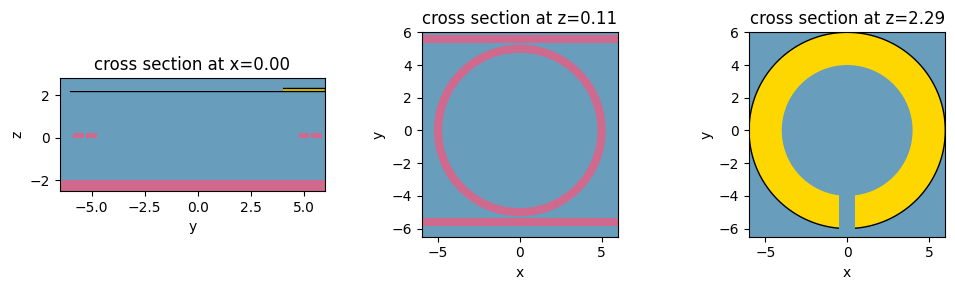

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
scene.plot(x=0, ax=ax[0])
scene.plot(z=z_wg, ax=ax[1])
scene.plot(z=z_heater, ax=ax[2])
plt.tight_layout()
plt.show()

We can also visualize structures according to their physical optic and thermal parameters.

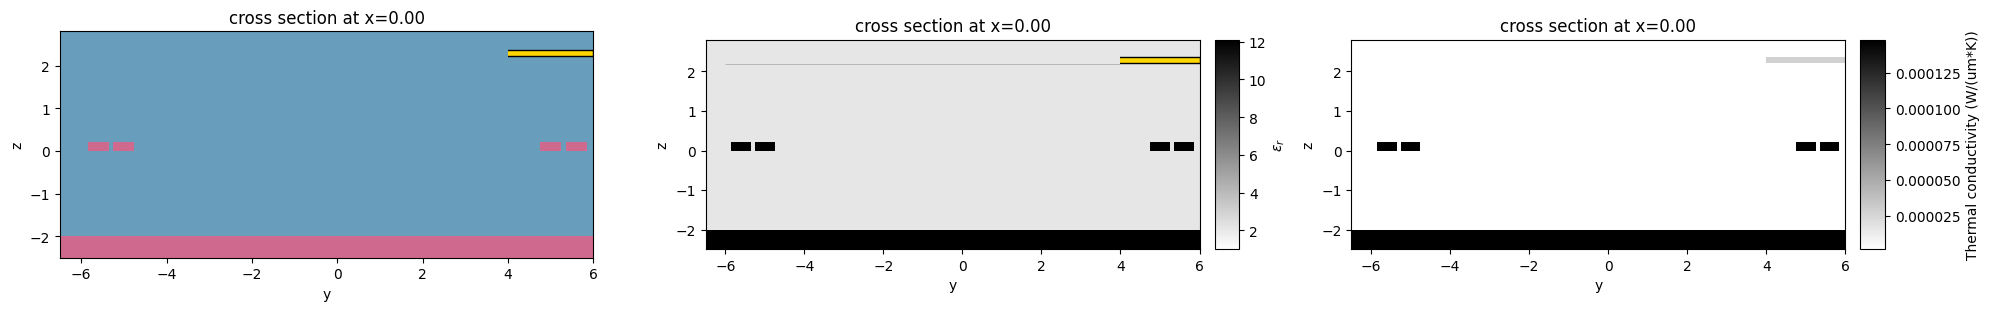

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
scene.plot(x=0, ax=ax[0])
scene.plot_eps(x=0, ax=ax[1])
scene.plot_heat_conductivity(x=0, ax=ax[2])
plt.tight_layout()
plt.show()

## Heat Simulation

To define a heat simulation setup ([HeatSimulation](../api/_autosummary/tidy3d.HeatSimulation.html)) based on the created [Scene](../api/_autosummary/tidy3d.Scene.html) object we need to define heat related specifications.

We start with specifying the simulation box dimensions. To do that we first define values for buffer space around created structures. We also define variable `heat_sim_buffer` that define how much larger a heat simulation is compared to an optic one. This is done to make sure that when an optic simulation is constructed we have valid temperature values in the PML regions as well. This will be applied only in x and y directions because the heat simulation is restricted to the region from the bottom of the wafer to the top of the cladding. This is because heat equation is not solved in mediums with `heat_spec=FluidSpec()`, which is true for medium `air` defined above.

In [13]:
x_buffer = 2  # buffer in x direction (from ring resonator)
y_buffer = 1  # buffer in y direction (from straight waveguides)
z_buffer = 1  # buffer in z direction

# difference between thermal and optic simulations
heat_sim_buffer = 3


Based on that compute simulation box size and its center along z.

In [14]:
z_sim = (h_clad - h_box - h_wafer) / 2
h_sim = h_box + h_clad + h_wafer + 2 * z_buffer
l_heat_sim = 2 * ring_radius + 2 * x_buffer + 2 * heat_sim_buffer
w_heat_sim = 2 * ring_radius + w_heater + 2 * y_buffer + 2 * heat_sim_buffer

Before proceeding we can inspect the chosen simulation box dimensions using [Scene](../api/_autosummary/tidy3d.Scene.html) plotting functions with custom vertical and horizontal extents.

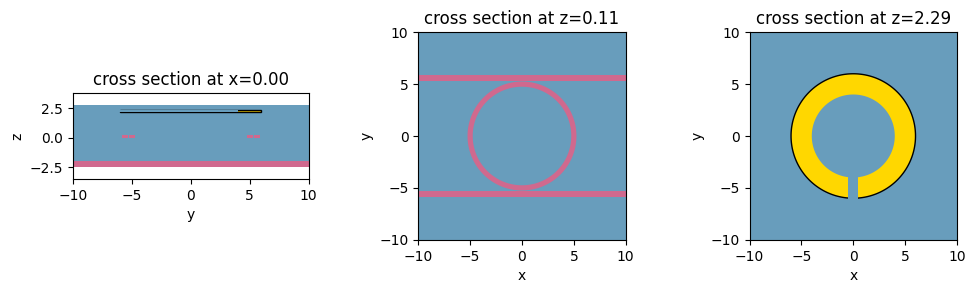

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
scene.plot(
    x=0, ax=ax[0], hlim=[-w_heat_sim / 2, w_heat_sim / 2], vlim=[z_sim - h_sim / 2, z_sim + h_sim / 2]
)
scene.plot(
    z=z_wg, ax=ax[1], hlim=[-l_heat_sim / 2, l_heat_sim / 2], vlim=[-w_heat_sim / 2, w_heat_sim / 2]
)
scene.plot(
    z=z_heater, ax=ax[2], hlim=[-l_heat_sim / 2, l_heat_sim / 2], vlim=[-w_heat_sim / 2, w_heat_sim / 2]
)
plt.tight_layout()
plt.show()

Having inspected that, let us proceed to other heat simulation specifications.

Create boundary conditions ([HeatBoundarySpec](../api/_autosummary/tidy3d.HeatBoundarySpec.html)) corresponding to temperature ([TemperatureBC](../api/_autosummary/tidy3d.TemperatureBC.html)) boundary conditions on the bottom of the wafer, and convective ([ConvectionBC](../api/_autosummary/tidy3d.ConvectionBC.html)) boundary condition at the cladding/air interface. Note that the convection heat transfer coefficient must be provided in units of W / (um^2 K). To specify the placement of these boundary conditions we use [MediumMediumInterface](../api/_autosummary/tidy3d.MediumMediumInterface.html) specification.

In [16]:
bc_air = td.HeatBoundarySpec(
    placement=td.MediumMediumInterface(mediums=[air.name, SiO2.name]), 
    condition=td.ConvectionBC(ambient_temperature=300, transfer_coeff=10 * 1e-6),
)
bc_wafer = td.HeatBoundarySpec(
    placement=td.MediumMediumInterface(mediums=[air.name, Si.name]), 
    condition=td.TemperatureBC(temperature=300),
)

Create a uniform heat source ([UniformHeatSource](../api/_autosummary/tidy3d.UniformHeatSource.html)) inside the ring heater to represent the Joule heating. For a given electric current in the heater $I$ we can approximately calculate the volumetric Joule heat generation using formula $\frac{dP}{dV} = \frac{1}{\sigma_{TiN}} \left( \frac{I}{w_{heater} h_{heater}} \right)^2$. For a current of 60 mA we get:

In [17]:
heat_current = 60e-3  # A
maximum_volumetric_heat = (heat_current / w_heater / h_heater) ** 2 / TiN_sigma  # W / um^3
print("Maximum volumetric heat rate: ", maximum_volumetric_heat, "W / um^3")

Maximum volumetric heat rate:  0.019964507542147288 W / um^3


For spatial discretization we will use class [DistanceUnstructuredGrid](../api/_autosummary/tidy3d.DistanceUnstructuredGrid.html) that specifies desired mesh size based on the distance from material interfaces. Given that `h_heater` is the smallest feature size of structures, we will select the mesh size near interfaces based on that. Mesh size away from interfaces is selected such that the coarse mesh would have approximately 15 points in the z-direction across the BOX + cladding region. Selecting `distance_interface` as `2 * dl_interface` we are enforcing approximately 2 layers of finest cells around interfaces. And `distance_bulk=h_box` makes the transition from the finest grid size to the coarsest grid size happen on the order of `h_box`. We also exclude structure `"wafer"` from enforcing `dl_interafce` since we are primarily interested in the temperature distribution in the waveguide region.

In [18]:
dl_interface = h_heater / 4
dl_bulk = (h_box + h_clad) / 15

heat_grid_spec=td.DistanceUnstructuredGrid(
    dl_interface=dl_interface, 
    dl_bulk=dl_bulk, 
    distance_interface=2 * dl_interface, 
    distance_bulk=h_box,
    non_refined_structures=["wafer"],
)

We will use the results of heat simulation in a subsequent optical simulation. Thus we will record a three-dimensional temperature distribution throughout the simulation domain with a [TemperatureMonitor](../api/_autosummary/tidy3d.TemperatureMonitor.html).

In [19]:
temp_mnt = td.TemperatureMonitor(size=(td.inf, td.inf, td.inf), name="all")

By default for convenience purposes, heat monitors return data on equivalent Cartesian grids. However, if the unprocessed data and/or the original unstructured grid are of interest, one can request that by setting `unstructured=True`. Additionally, the option `conformal=True` allows to request the monitor to be meshed conformally on the unstructured grid. This is useful for visualization purposes, because plots of slices of tetrahedral grids maybe be confusing for visual inspection. Here, we will create monitors with and without conformal meshing for demonstration purposes. In total, we create 3 planar monitors: horizontal through the waveguie structure, horizontal through the heater, and a vertical one.

In [20]:
temp_mnt_ugrid_wg = td.TemperatureMonitor(size=(td.inf, td.inf, 0), center=(0, 0, z_wg), name="ugrid_wg", unstructured=True, conformal=True)
temp_mnt_ugrid_heater = td.TemperatureMonitor(size=(td.inf, td.inf, 0), center=(0, 0, z_heater), name="ugrid_heater", unstructured=True)
temp_mnt_ugrid_vert = td.TemperatureMonitor(size=(0, td.inf, td.inf), center=(1e-3, 0, 0), name="ugrid_vert", unstructured=True)

Combining everything into a [HeatSimulation](../api/_autosummary/tidy3d.HeatSimulation.html) instance. Instead of specifying structures and background medium by hand, we use a convenience class method `from_scene()`. Note that from the point of view of heat distribution this problem is symmetric with respect to $x = 0$. Thus, we can use field `symmetry` to reduce the size, time, and cost for the heat simulation.

However, here is where our simulation configuration will begin to vary in order to implement the co-simulation example. 

In [21]:
def heat_rate_presimulation(rate: float) -> td.HeatSimulation:
    source_i = td.UniformHeatSource(structures=["heater_outer"], rate=rate)
    heat_sim = td.HeatSimulation.from_scene(
        scene=scene,
        size=[l_heat_sim, w_heat_sim, h_sim],
        center=(0, 0, z_sim),
        grid_spec=heat_grid_spec,
        sources=[source_i],
        boundary_spec=[bc_air, bc_wafer],
        symmetry=(1, 0, 0),
        monitors=[temp_mnt, temp_mnt_ugrid_wg, temp_mnt_ugrid_heater, temp_mnt_ugrid_vert],
    )
    return heat_sim

def heat_rate_postsimulation(data: td.HeatSimulationData) -> td.HeatSimulationData:
    return data

Visualization of [HeatSimulation](../api/_autosummary/tidy3d.HeatSimulation.html) object displays:
- thermal conductivity of structures (in grayscale colors),
- specified boundary conditions (colored thick lines: yellow for [TemperatureBC](../api/_autosummary/tidy3d.TemperatureBC.html), green for [HeatFluxBC](../api/_autosummary/tidy3d.HeatFluxBC.html), and red for [ConvectionBC](../api/_autosummary/tidy3d.ConvectionBC.html)),
- heat sources (in colored dotted hatching),
- and monitors (in transparent yellow color).

0.0 0.0


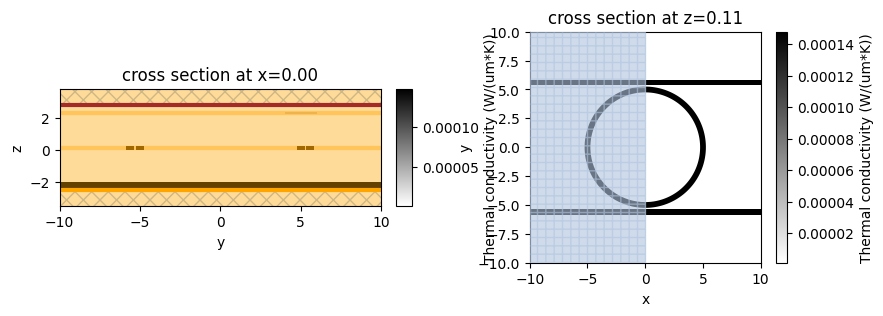

In [22]:
sim = heat_rate_presimulation(rate=0)

# plot the two simulations
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sim.plot_heat_conductivity(x=0.0, ax=ax[0], source_alpha=0)
sim.plot_heat_conductivity(z=z_wg, ax=ax[1], monitor_alpha=0)
plt.show()

In [23]:
heat_rate_parameter = tdd.ParameterFloat(name="rate", num_points=8, span=(0, maximum_volumetric_heat)) # tdd.ParameterAny(name='rate', allowed_values=tuple(pulse.tolist()))
heat_rate_method = tdd.MethodGrid()
heat_rate_design_space = tdd.DesignSpace(parameters=[heat_rate_parameter], method=heat_rate_method)

In [24]:
heat_rate_space_simulation_data = heat_rate_design_space.run_batch(heat_rate_presimulation, heat_rate_postsimulation)

15:05:38 CET Created task '{'rate': 0.0}' with task_id                          
             'he-c95ae527-7643-48df-8289-9e088d9226eb' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:40 CET Created task '{'rate': 0.0028520725060210412}' with task_id        
             'he-0f686fd8-7904-487d-8acf-21659338ee4a' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:42 CET Created task '{'rate': 0.0057041450120420825}' with task_id        
             'he-fdbaf5ca-e9a7-4335-aef7-21e45c22062a' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:44 CET Created task '{'rate': 0.008556217518063123}' with task_id         
             'he-af116a12-08d1-484a-b7c7-f4c9cbcebae4' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:45 CET Created task '{'rate': 0.011408290024084165}' with task_id         
             'he-f78f7992-9d37-4943-94e9-073e9c78e0f0' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:47 CET Created task '{'rate': 0.014260362530105207}' with task_id         
             'he-aa5eb9cb-8674-407f-b8dd-4f2fc0fe3120' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:48 CET Created task '{'rate': 0.017112435036126247}' with task_id         
             'he-fe4f16b4-30ee-4adc-9b09-2dbb612b85de' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:50 CET Created task '{'rate': 0.019964507542147288}' with task_id         
             'he-1608bbb9-3c18-4206-8101-dc63bf50b7d6' and task_type 'HEAT'.

             Tidy3D's heat solver is currently in the beta stage. Cost of heat  
             simulations is subject to change in the future.

Output()

15:05:56 CET Started working on Batch.

15:06:27 CET Maximum FlexCredit cost: 0.200 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

15:06:33 CET Batch complete.

Output()

15:06:39 CET loading simulation from                                            
             ./he-c95ae527-7643-48df-8289-9e088d9226eb.hdf5

Output()

15:06:50 CET loading simulation from                                            
             ./he-0f686fd8-7904-487d-8acf-21659338ee4a.hdf5

Output()

15:07:13 CET loading simulation from                                            
             ./he-fdbaf5ca-e9a7-4335-aef7-21e45c22062a.hdf5

Output()

15:07:30 CET loading simulation from                                            
             ./he-af116a12-08d1-484a-b7c7-f4c9cbcebae4.hdf5

Output()

15:07:45 CET loading simulation from                                            
             ./he-f78f7992-9d37-4943-94e9-073e9c78e0f0.hdf5

Output()

15:07:57 CET loading simulation from                                            
             ./he-aa5eb9cb-8674-407f-b8dd-4f2fc0fe3120.hdf5

Output()

15:08:09 CET loading simulation from                                            
             ./he-fe4f16b4-30ee-4adc-9b09-2dbb612b85de.hdf5

Output()

15:08:22 CET loading simulation from                                            
             ./he-1608bbb9-3c18-4206-8101-dc63bf50b7d6.hdf5

<Axes: title={'center': 'cross section at z=0.11'}, xlabel='x', ylabel='y'>

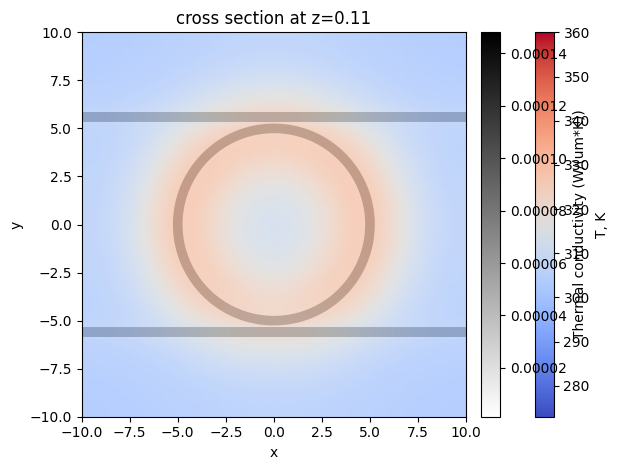

In [25]:
heat_rate_space_simulation_data.values[1].plot_field("ugrid_wg", vmin=273, vmax=360)

In [26]:
import matplotlib.animation as animation
from IPython.display import HTML

frames = len(heat_rate_space_simulation_data.values)  # number of frames

fig, ax = plt.subplots()

def animate(i):
    heat_rate_space_simulation_data.values[i].plot_field("ugrid_wg", ax=ax, vmin=273, vmax=350, cbar=False)
        
# create animation
heat_animiation = animation.FuncAnimation(fig, animate, frames=frames);
plt.close()

# display the animation
HTML(heat_animiation.to_jshtml())
heat_animiation.save(filename="heat_temperature.gif", writer="pillow")

In [27]:
heat_sim_data = heat_rate_space_simulation_data.values[-1]

Now we can submit our heat simulation setup for solving on our servers.

This will approximately take a few minutes to finish running all the tasks, make sure to keep track of the task_id, and then it's possible to load the simulation.

heat_sim_data = web.run(sim, "thermal-pulse-ring")

The result of this calculation are returned as an [HeatSimulationData](../api/_autosummary/tidy3d.HeatSimulationData.html) instance containing the calculated temperature field. Both unstructured and structured monitor can be used for visualizing resulting temperature fields.

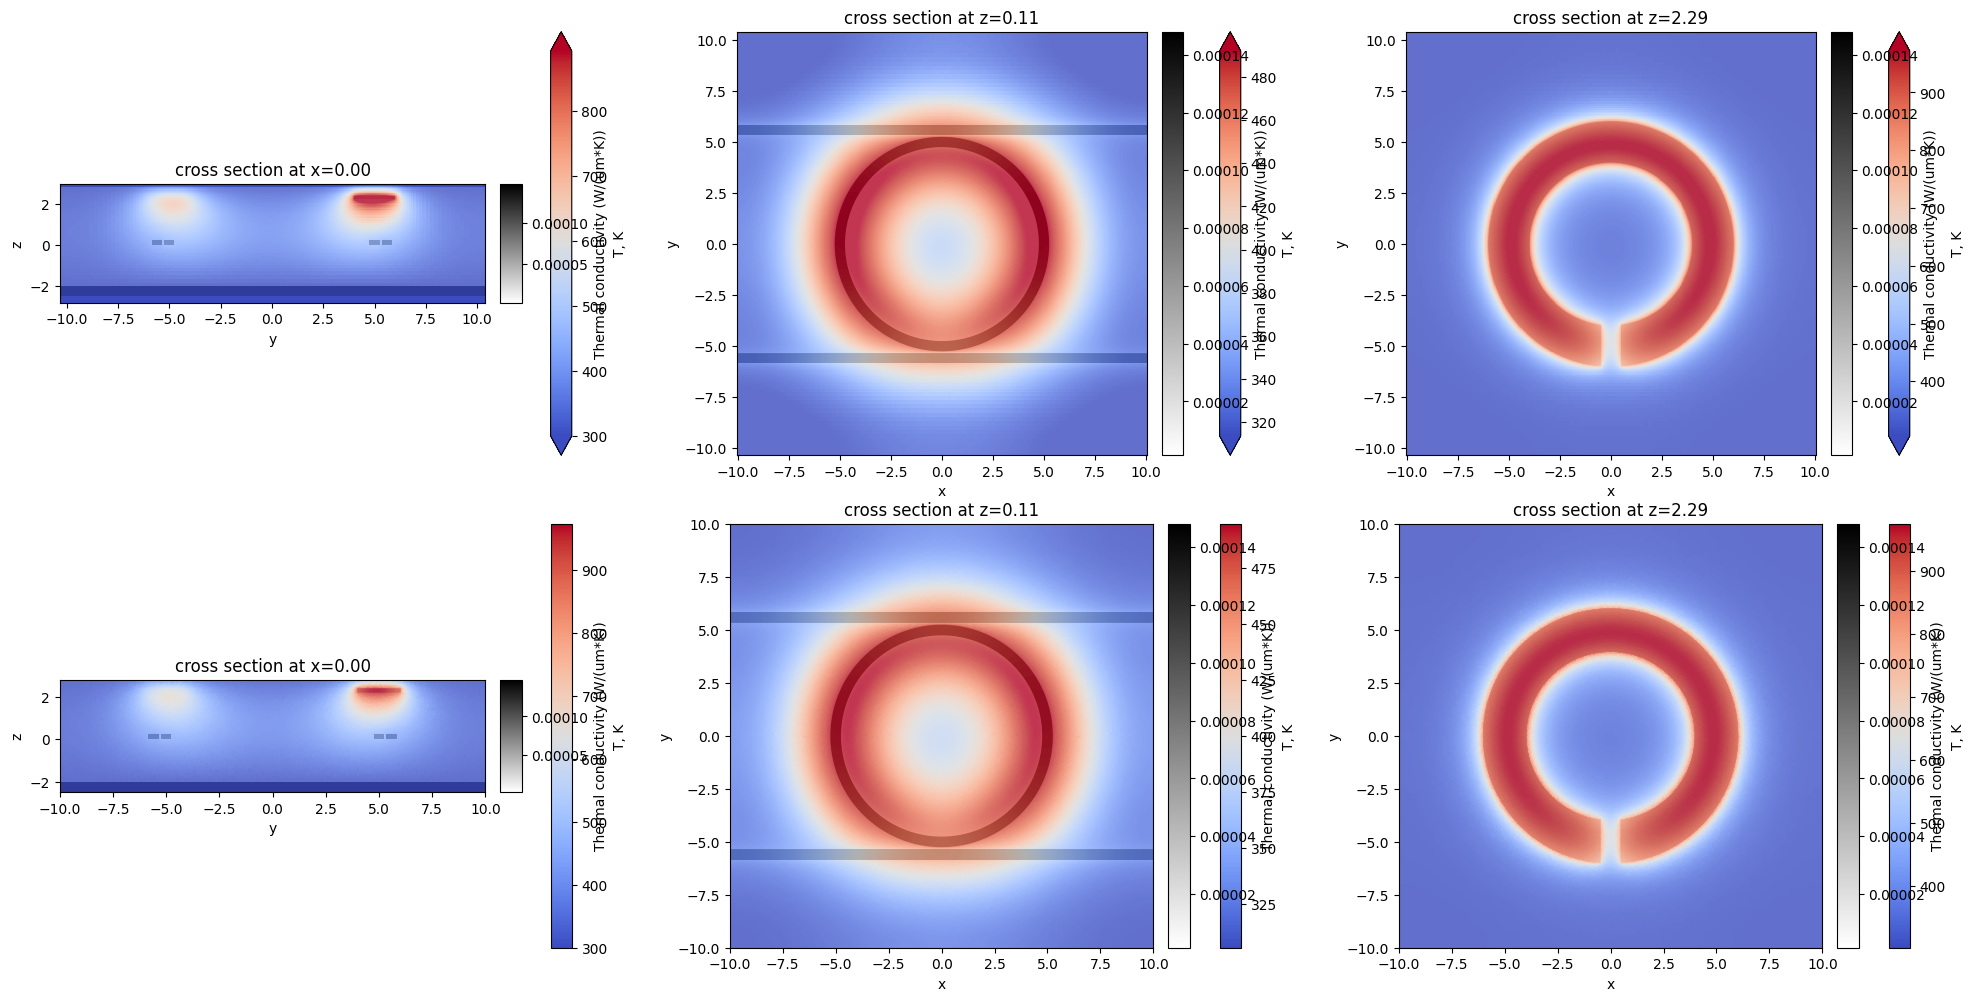

In [28]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

heat_sim_data.plot_field("all", x=0, ax=ax[0, 0])
heat_sim_data.plot_field("all", z=z_wg, ax=ax[0, 1])
heat_sim_data.plot_field("all", z=z_heater, ax=ax[0, 2])

heat_sim_data.plot_field("ugrid_vert", ax=ax[1, 0])
heat_sim_data.plot_field("ugrid_wg", ax=ax[1, 1])
heat_sim_data.plot_field("ugrid_heater", ax=ax[1, 2])

plt.tight_layout()
plt.show()

The unstructured monitors can also be used to visualize the unstructured grid used by heat solver. Note the difference between resulting grids for conformal and non-conformal monitors. In the former case the monitor plane conforms to finite element cells, while in the latter case the resulting dataset is the result of slicing unstructured tetrahedral grid.

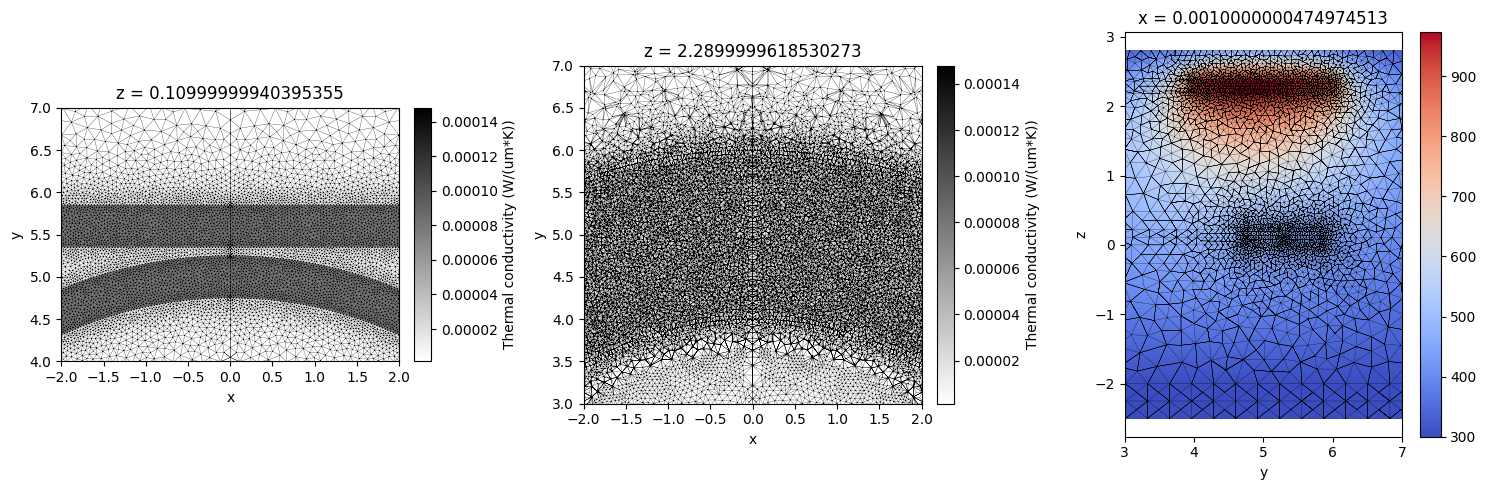

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sim.plot_structures_heat_conductivity(z=z_wg, ax=ax[0], alpha=0.5)
heat_sim_data["ugrid_wg"].temperature.plot(ax=ax[0], field=False)
ax[0].set_xlim([-2, 2])
ax[0].set_ylim([4, 7])

sim.plot_structures_heat_conductivity(z=z_heater, ax=ax[1], alpha=0.5)
heat_sim_data["ugrid_heater"].temperature.plot(ax=ax[1], field=False)
ax[1].set_xlim([-2, 2])
ax[1].set_ylim([3, 7])

heat_sim_data["ugrid_vert"].temperature.plot(ax=ax[2], cmap="coolwarm")
ax[2].set_xlim([3, 7])


plt.tight_layout()
plt.show()

Tidy3D provides a basic functionality for visualization of unstructured data. If a more thorough inspection is required we recommend to export the results into a `vtu` file using `.to_vtu()`method, for example: 
```
heat_sim_data["ugrid_wg"].temperature.to_vtu("heat_mnt.vtu")
```
and processing it using dedicated visualization software like Paraview.

## Perturbed Scene

The obtained temperature field information can be applied to mediums present in the scene so that their optical properties are appropriately modified. This can be done by using function `scene.perturbed_mediums_copy(temperature: SpatialDataArray)`. Note that in this case it triggers several warnings because some of the structures are extending well beyond temperature field. This is expected because the heat equation was solved on a bound region. Also, this will not have an adverse effect on optic simulations, because in the optic simulations we are going to run the simulation domain will be fully covered y available temperature data.

In [30]:
perturbed_scene = scene.perturbed_mediums_copy(
    temperature=heat_sim_data["all"].temperature
)

15:09:09 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:10 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

We can compare the permittivity fields of the original and perturbed scenes. Note that both ring resonator and waveguides are affected by the heat.

In [31]:
import matplotlib.animation as animation
from IPython.display import HTML

frames = len(heat_rate_space_simulation_data.values)  # number of frames

fig, ax = plt.subplots(figsize=(10, 5))
eps_lim = [12.08, 12.18]

def animate(i):
    scene_i = scene.perturbed_mediums_copy(
        temperature=heat_rate_space_simulation_data.values[i]["all"].temperature
    )
    scene_i.plot_structures_eps(z=z_wg, eps_lim=eps_lim, ax=ax)
    
# create animation
ani = animation.FuncAnimation(fig, animate, frames=frames);
plt.close()

# display the animation
HTML(ani.to_jshtml())
ani.save(filename="heat_permittivity.gif", writer="pillow")

             WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:11 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:12 CET WARNING: Provided 'temperature' does not fully cover structures[0].

             WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:14 CET WARNING: Provided 'temperature' does not fully cover structures[0].

             WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

15:09:15 CET WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:16 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:17 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:19 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:20 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:22 CET WARNING: Provided 'temperature' does not fully cover structures[0].

             WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

15:09:23 CET WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:25 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:26 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:28 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:29 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:32 CET WARNING: Provided 'temperature' does not fully cover structures[0].

             WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:35 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:36 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:37 CET WARNING: Provided 'temperature' does not fully cover structures[0].

             WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

15:09:38 CET WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:41 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:42 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:45 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:46 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:50 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:51 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:09:55 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:09:56 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:10:00 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:10:01 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:10:05 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:10:06 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

15:10:11 CET WARNING: Provided 'temperature' does not fully cover structures[0].

15:10:12 CET WARNING: Provided 'temperature' does not fully cover structures[3].

             WARNING: Provided 'temperature' does not fully cover structures[4].

             WARNING: Provided 'temperature' does not fully cover structures[8].

<Figure size 640x480 with 0 Axes>

## Optic simulations

Now one can run optical simulation on both scenes to investigate the influence of heat on electromagnetic response.

As mentioned above, compared to the heat simulation, the optic simulation will have smaller dimensions in $x$ and $y$ directions. Also, since heater and wafer structures are not expected to have significant influence on propagation in the waveguides we will set the size of simulation in z direction to 3 $\mu$m.

In [32]:
l_optic_sim = l_heat_sim - 2 * heat_sim_buffer
w_optic_sim = w_heat_sim - 2 * heat_sim_buffer
h_optic_sim = 3

Define the wavelength range of interest and corresponding frequency values.

In [33]:
# wavelength range of interest
lambda_beg = 1.5
lambda_end = 1.6

# define pulse parameters
freq_beg = td.C_0 / lambda_end
freq_end = td.C_0 / lambda_beg
freq0 = (freq_beg + freq_end) / 2
fwidth = (freq_end - freq0) / 1.5

We will inject a waveguide mode into the upper left arm of the structure.

In [34]:
# calculate x-distance for mode source and mode monitors
wg_insert_x = ring_radius + 0.9 * x_buffer

mode_plane = td.Box(
    center=[-wg_insert_x, y_wg, z_wg],
    size=[0, 2, 2],
)

mode_source = td.ModeSource(
    size=mode_plane.size,
    center=mode_plane.center,
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    mode_index=0,
    direction="+",
    num_freqs=7,  # using 7 (Chebyshev) points to approximate frequency dependence
)

We will monitor the field distribution at the central wavelength in the xy plane passing through waveguide structures and mode amplitudes in the through and drop ports.

In [35]:
# monitor steady state fields at central frequency over whole domain
# frequency is chosen based on simulation results for clearer demonstration
field_monitor = td.FieldMonitor(
    center=[0, 0, z_wg], size=[td.inf, td.inf, 0], freqs=[1.93831331e+14], name="field"
)

# monitor the mode amps on the output waveguide
lambdas_measure = np.linspace(lambda_beg, lambda_end, 301)
freqs_measure = td.C_0 / lambdas_measure[::-1]

through_mode_mnt = td.ModeMonitor(
    size=mode_plane.size,
    center=[wg_insert_x, y_wg, z_wg],
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode through",
)

drop_mode_mnt = td.ModeMonitor(
    size=mode_plane.size,
    center=[-wg_insert_x, -y_wg, z_wg],
    freqs=freqs_measure,
    mode_spec=td.ModeSpec(num_modes=2),
    name="mode drop",
)

Define the remaining optic simulation parameters such as grid resolution and total simulation time, and create [Simulation](../api/_autosummary/tidy3d.Simulation.html) instances for both the original and perturbed simulation scenes.

In [36]:
def fdtd_heat_rate_presimulation(heat_sim_data_index: int):
    min_steps_per_wvl = 15
    run_time = 8e-11
    
    base_sim = td.Simulation.from_scene(
        scene=scene,
        size=[l_optic_sim, w_optic_sim, h_optic_sim],
        center=(0, 0, z_sim),
        grid_spec=td.GridSpec.auto(
            min_steps_per_wvl=min_steps_per_wvl, wavelength=td.C_0 / freq0
        ),
        sources=[mode_source],
        monitors=[field_monitor, through_mode_mnt, drop_mode_mnt],
        shutoff=1e-7,
        run_time=run_time,
    )
    
    sim = base_sim.perturbed_mediums_copy(
        temperature=heat_rate_space_simulation_data.values[heat_sim_data_index]["all"].temperature
    )

    sim = sim.subsection(
        region=base_sim.bounding_box, remove_outside_structures=True, remove_outside_custom_mediums=True
    )
    
    return sim

def fdtd_heat_rate_postsimulation(data: td.SimulationData) -> td.SimulationData:
    return data

In [37]:
# fdtd_heat_rate_parameter = tdd.ParameterAny(name="heat_sim_data", allowed_values=heat_rate_space_simulation_data.values)
fdtd_heat_rate_parameter_index = tdd.ParameterAny(name="heat_sim_data_index",
                                                  allowed_values=tuple(range(len(heat_rate_space_simulation_data.values))))
fdtd_heat_rate_method = tdd.MethodGrid()
fdtd_design_space = tdd.DesignSpace(name="fdtd_heat_rate", parameters=[fdtd_heat_rate_parameter_index], method=fdtd_heat_rate_method)

In [ ]:
fdtd_heat_rate_simulation_data = fdtd_design_space.run_batch(fdtd_heat_rate_presimulation, fdtd_heat_rate_postsimulation)

15:10:16 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:17 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:25 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:26 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:33 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:34 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:42 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:43 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:50 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:51 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:10:59 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:00 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:08 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:09 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:17 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:18 CET WARNING: 'simulation.structures[5]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[6]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[7]'is completely outside of        
             simulation domain.                                                 

             WARNING: 'simulation.structures[8]'is completely outside of        
             simulation domain.                                                 

             WARNING: Structure at structures[7] was detected as being less than
             half of a central wavelength from a PML on side y-min. To avoid    
             inaccurate results or divergence, please increase gap between any  
             structures and PML or fully extend structure through the pml.      

15:11:26 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

15:11:27 CET Created task '{'heat_sim_data_index': 0}' with task_id             
             'fdve-890614d3-553a-44da-babe-b48c1f709ca3' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=860971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=485560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\taskId]8;;\]8;id=860971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\=]8;;\]8;id=765231;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\fdve]8;;\]8;id=860971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\-890614d3-553]8;;\
             ]8;id=860971;https://tidy3d.simulation.cloud/workbench?taskId=fdve-890614d3-553a-44da-babe-b48c1f709ca3\a-44da-babe-b48c1f709ca3']8;;\.

Output()

15:12:11 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 1}' with task_id             
             'fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=780381;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=321109;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\taskId]8;;\]8;id=780381;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\=]8;;\]8;id=710598;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\fdve]8;;\]8;id=780381;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\-e53dd73f-820]8;;\
             ]8;id=780381;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e53dd73f-8203-4d7f-9df6-a2117fef5cae\3-4d7f-9df6-a2117fef5cae']8;;\.

Output()

15:14:11 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 2}' with task_id             
             'fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=673946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=237238;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\taskId]8;;\]8;id=673946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\=]8;;\]8;id=919266;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\fdve]8;;\]8;id=673946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\-3a3a5186-ebc]8;;\
             ]8;id=673946;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3a3a5186-ebc3-4042-b7a2-d6b0a6ce4e46\3-4042-b7a2-d6b0a6ce4e46']8;;\.

Output()

15:15:40 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 3}' with task_id             
             'fdve-383b12c6-39e4-4d61-ae5f-917283c8877b' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=707044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=885713;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\taskId]8;;\]8;id=707044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\=]8;;\]8;id=898793;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\fdve]8;;\]8;id=707044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\-383b12c6-39e]8;;\
             ]8;id=707044;https://tidy3d.simulation.cloud/workbench?taskId=fdve-383b12c6-39e4-4d61-ae5f-917283c8877b\4-4d61-ae5f-917283c8877b']8;;\.

Output()

15:16:51 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 4}' with task_id             
             'fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=578205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=974023;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\taskId]8;;\]8;id=578205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\=]8;;\]8;id=906538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\fdve]8;;\]8;id=578205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\-a0a5ceb8-9c7]8;;\
             ]8;id=578205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a0a5ceb8-9c70-4f7b-936b-e0760f5e5ab4\0-4f7b-936b-e0760f5e5ab4']8;;\.

Output()

15:17:52 CET WARNING: Simulation has 1.55e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 5}' with task_id             
             'fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=741561;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=159150;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\taskId]8;;\]8;id=741561;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\=]8;;\]8;id=499866;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\fdve]8;;\]8;id=741561;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\-5e0d1aa2-f7e]8;;\
             ]8;id=741561;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5e0d1aa2-f7eb-49f3-b955-1d188d035eb5\b-49f3-b955-1d188d035eb5']8;;\.

Output()

15:18:46 CET WARNING: Simulation has 1.57e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 6}' with task_id             
             'fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=710443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=406495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\taskId]8;;\]8;id=710443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\=]8;;\]8;id=521419;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\fdve]8;;\]8;id=710443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\-fc7e22e5-1b8]8;;\
             ]8;id=710443;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc7e22e5-1b86-481b-baf2-ae73ff5583a7\6-481b-baf2-ae73ff5583a7']8;;\.

Output()

15:19:38 CET WARNING: Simulation has 1.57e+06 time steps. The 'run_time' may be 
             unnecessarily large, unless there are very long-lived resonances.  

             Created task '{'heat_sim_data_index': 7}' with task_id             
             'fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=340972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=433657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\taskId]8;;\]8;id=340972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\=]8;;\]8;id=639277;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\fdve]8;;\]8;id=340972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\-4e7cc3d7-d08]8;;\
             ]8;id=340972;https://tidy3d.simulation.cloud/workbench?taskId=fdve-4e7cc3d7-d08b-4c83-a43c-54ecff0bd4fc\b-4c83-a43c-54ecff0bd4fc']8;;\.

Output()

15:21:00 CET Started working on Batch.

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

frames = len(fdtd_heat_rate_simulation_data.values)  # number of frames

fig, ax = plt.subplots()

def animate_fdtd(i):
    fdtd_heat_rate_simulation_data.values[i].plot_field("field", "E", "abs", z=z_wg, ax=ax, cbar=False)
        
# create animation
fdtd_animation = animation.FuncAnimation(fig, animate_fdtd, frames=frames);
plt.close()

# display the animation
HTML(fdtd_animation.to_jshtml())

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Prepare the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
frames = len(fdtd_heat_rate_simulation_data.values)  # number of frames


def animate_coupled(i):
    heat_rate_space_simulation_data.values[i].plot_field("ugrid_wg", ax=ax1, vmin=273, vmax=350, cbar=False)
    fdtd_heat_rate_simulation_data.values[i].plot_field("field", "E", "abs", z=z_wg, ax=ax2, cbar=False)
    ax1.set_ylim([-7, 7])
    ax2.set_ylim([-7, 7])
    ax1.set_xlim([-7, 7])
    ax2.set_xlim([-7, 7])
    ax1.set_aspect('auto')
    ax2.set_aspect('auto')
    

coupled_animation = animation.FuncAnimation(fig, animate_coupled, frames=frames)
plt.close()

# display the animation
coupled_animation.save(filename="coupled_animation.gif", writer="pillow")
HTML(coupled_animation.to_jshtml())

In [ ]:
fig